In this project, I implement a neural style transfer algorithm on my professional headshot and use NumPy docstrings to document each function I use along the way. Lets get started:


## Neural Style Transfer
---
Neural style transfer is a type of algorithm that merges two images: one is this "content" image (C) and the other is a "style" image (S). These two are blended to create a "generated" image (G) which presents the content of image C with the style of image S. While most neural net algorithms optimize a cost function to get parameter values, this algorithm optimizes a cost function to get pixel values.

The neural style transfer algorithm that I implement in this project was created by Gatys et al. (2015) (https://arxiv.org/pdf/1508.06576.pdf)

## NumPy Docstrings
---
Numpy style has a lot of details in the documentation compared to other documentation styles. It is more verbose than other documentation, but it is an excellent choice if you want to do detailed documentation, i.e., extensive documentation of all the functions and parameters. I figured that I could get some practice in using this format even though this is not typical for deep learning. Here is a guide on NumPy docstrings: https://numpydoc.readthedocs.io/en/latest/format.html


### Imports

In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

C:\Users\Ryan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The results presented in the paper I linked above were generated using the VGG-Network, a Convolutional Neural Network that rivals human performance on a common visual object recognition benchmark task. This model has already been trained on the very large ImageNet database, and thus has learned to recognize a variety of low level features (in the earlier layers) and high level features (in the deeper layers). This algorithm is a successful example of transfer learning where you take a network trained on a different task and apply it to a new one.

I downloaded the model here: https://www.kaggle.com/teksab/imagenetvggverydeep19mat/kernels

In [2]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shap

I build the NST algorithm in three steps:

1. Build the content cost function $J_{content}(C,G)$
2. Build the style cost function $J_{style}(S,G)$
3. Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 

### Step 1) Build the Content Cost Function

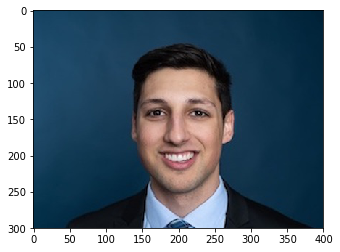

In [3]:
content_image = scipy.misc.imread("images/prof_pic.jpg")
imshow(content_image)

This is the given formula for the content cost I will use in my function below:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

In [4]:
def compute_content_cost(a_C, a_G):
    """Computes the content image cost
    
    Parameters
    ----------
    a_C : Tensor
        Hidden layer activations representing the "content" image C with dimensions (1, n_H, n_W, n_C)
    a_G : Tensor
        Hidden layer activations representing the "generated" image G with dimensions (1, n_H, n_W, n_C)
    
    Returns
    -------
    float
        Scalar representing the content cost that you compute using equation 1 above.
    """
    
    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G
    a_C_unrolled = tf.transpose(tf.reshape(a_C,[-1]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G,[-1]))
    
    # Compute cost
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled))/(4*n_H*n_W*n_C))
    
    return J_content

### Step 2) Build the Style Cost Function

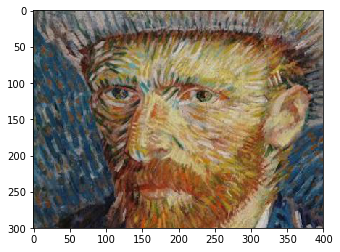

In [5]:
style_image = scipy.misc.imread("images/prof_pic_style.jpg")
imshow(style_image)

This is the given formula for the style cost I will use in my function below:

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$

where $G^{(S)}$ and $G^{(G)}$ are respectively the Gram matrices of the "style" image and the "generated" image, computed using the hidden layer activations for a particular hidden layer in the network. A gram matrix essentially compares the similarity between vectors as shown here:

![](images/gram.png)

In [6]:
def compute_layer_style_cost(a_S, a_G):
    """Computes the style cost of one layer 
    
    Parameters
    ----------
    a_S : Tensor
        Hidden layer activations representing style of the image S with dimensions (1, n_H, n_W, n_C) 
    a_G : Tensor
        Hidden layer activations representing style of the image G with dimensions (1, n_H, n_W, n_C)
    
    Returns
    -------
    Tensor
        Represents a scalar value that shows the style cost for a layer
    """
    
    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_H*n_W, n_C)
    a_S = tf.reshape(a_S,shape=[n_H*n_W,n_C])
    a_G = tf.reshape(a_G,shape=[n_H*n_W,n_C])

    # Compute gram_matrices for both images S and G
    GS = tf.matmul(tf.transpose(a_S), a_S)
    GG = tf.matmul(tf.transpose(a_G), a_G)
    
    # Compute the loss
    J_style_layer = tf.reduce_sum((GS - GG)**2) / (4 * n_C**2 * (n_W * n_H)**2)
    
    return J_style_layer

In [7]:
def compute_style_cost(model, STYLE_LAYERS):
    """Computes the overall style cost from several chosen layers
    
    Arguments
    ---------
    model : dict
        Pretrained VGG-Network
    STYLE_LAYERS : list 
        Contains the names of the layers from style and a coefficient for each of them
    
    Returns
    -------
    Tensor
        Represents a scalar value that shows the style cost computed using equation 2 above
    """
    
    # Initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the selected layer by using "out" to run the session
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to the overall style cost
        J_style += coeff * J_style_layer

    return J_style

### Step 3) Creating overall cost function
---
Lastly, I create the overall cost function using the following formula: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)\tag{3}$$

In [8]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """Computes the total cost function
    
    Parameters
    ----------
    J_content : float
        Content cost coded above
    J_style : float
        Style cost coded above
    alpha : float 
        Hyperparameter weighting the importance of the content cost
    beta : float
        Hyperparameter weighting the importance of the style cost
    
    Returns
    -------
    float
        Total cost as defined by formula 3 above
    """
    
    J = alpha*J_content + beta*J_style
    
    return J

## Implementing the Neural Style Transfer Algorithm
---

In [9]:
#start session. I use tf.InteractiveSession() so that I do not have to call sess every time I want to make a command
sess = tf.InteractiveSession()

In [10]:
content_image = scipy.misc.imread("prof_pic.jpg")
content_image = reshape_and_normalize_image(content_image)
content_image.shape

(1, 300, 400, 3)

In [11]:
style_image = scipy.misc.imread("prof_pic_style.jpg")
style_image = reshape_and_normalize_image(style_image)
style_image.shape

(1, 300, 400, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


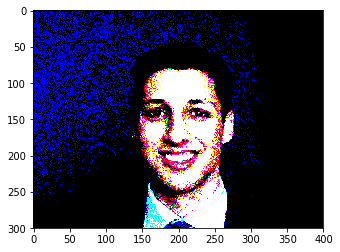

In [12]:
# Initialize generated image
# By initializing the pixels of the generated image to be mostly noise but still slightly correlated with the content image, 
# the contents of the "generated" image should more rapidly match the contents of the "content" image
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [13]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

In [14]:
# Assign the content image to be the input of the VGG model
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [15]:
# Weights for style layers used in my style cost function
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [16]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [17]:
#determine total cost of neural style transfer
J = total_cost(J_content,J_style)

In [18]:
# define optimizer
optimizer = tf.train.AdamOptimizer(2.0)

# define training step
train_step = optimizer.minimize(J)

In [19]:
def model_nn(sess, input_image, num_iterations = 200):
    """Function for displaying generated image
    
    Prints costs and saves image every 20 iterations and returns 
    the generated image after a selected number of iterations.
    
    Parameters
    ----------
    sess : tf.InteractiveSession
        A TensorFlow session
    input_image : numpy.ndarray
        Initialized generated image of dimension (1, 300, 400, 3)
    
    Returns
    -------
    numpy.ndarray
        Generated image of dimension (1, 300, 400, 3)
    """
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + ":")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            print()
            
            # save current generated image
            save_image(str(i) + ".png", generated_image)
    
    # save last generated image
    save_image("generated_image.jpg", generated_image)
    
    return generated_image

In [20]:
model_nn(sess, generated_image)

Iteration 0:
total cost = 2188365300.0
content cost = 11130.902
style cost = 54706348.0

Iteration 20:
total cost = 137819060.0
content cost = 17929.898
style cost = 3440994.0

Iteration 40:
total cost = 47573010.0
content cost = 18800.924
style cost = 1184625.0

Iteration 60:
total cost = 26807062.0
content cost = 19188.49
style cost = 665379.44

Iteration 80:
total cost = 19645014.0
content cost = 19291.395
style cost = 486302.5

Iteration 100:
total cost = 15923891.0
content cost = 19376.914
style cost = 393253.06

Iteration 120:
total cost = 13490631.0
content cost = 19452.215
style cost = 332402.72

Iteration 140:
total cost = 11713548.0
content cost = 19521.186
style cost = 287958.4

Iteration 160:
total cost = 10332546.0
content cost = 19586.777
style cost = 253416.94

Iteration 180:
total cost = 9220304.0
content cost = 19640.297
style cost = 225597.52



array([[[[-31.421114  ,  -1.7869743 ,   5.9090214 ],
         [-57.722103  , -26.125952  , -20.510908  ],
         [-81.335396  , -47.773224  , -30.476816  ],
         ...,
         [-36.62536   ,  -3.9274855 ,   7.392635  ],
         [-39.093464  ,   8.135469  ,  19.68169   ],
         [-25.393538  ,   0.8265144 ,   9.28708   ]],

        [[-21.137295  ,  15.879133  ,  15.224572  ],
         [-45.938606  , -12.138373  ,  -6.038957  ],
         [-74.80834   , -41.120636  , -16.837288  ],
         ...,
         [-20.341497  ,  -7.4911766 , -12.874371  ],
         [-23.00922   , -16.21238   ,  15.472856  ],
         [-22.149517  ,  -6.4355454 ,   9.084199  ]],

        [[-31.979158  ,  10.448174  ,  17.303883  ],
         [-29.769411  ,  -3.303211  ,   0.791609  ],
         [-51.725124  , -41.711693  , -27.05746   ],
         ...,
         [-33.48656   ,   2.8272018 , -12.956705  ],
         [-16.162848  , -20.271004  ,  12.691628  ],
         [-14.867073  , -26.060982  ,  -0.34076917]],

# Time-lapse of Generated Image
---
Shown below you see the initialized generated image in the leftmost window and the fairly rapid transition to arrive at the final image in around 100 iterations.
![](images/timelapse.png)

# Finished Product
---
Generated Image (G) = Top                                              
Content Image (C) = Bottom left                                          
Style Image (S) = Bottom right
![](images/collage.jpg)